In [2]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt
torch.__version__

'2.6.0+cpu'

## **PyTorch Workflow**

### **Data (preparing and loading)**

Data can be almost everything in machine learning. For example:
* Exel spreadsheet
* Images of any kind
* Videos
* Signals
* DNA
* Text
* ...

Machine learning is a game of two parts:
* Get data into a numerical representation
* Build a model to learn patterns in that numerical representation

In [3]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create a tensor and and an array
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

print(f"Tensor X (first ten values):\n {X[:10]}")
print(f"\nArray y (first ten values):\n {y[:10]}")

Tensor X (first ten values):
 tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800]])

Array y (first ten values):
 tensor([[0.3000],
        [0.3140],
        [0.3280],
        [0.3420],
        [0.3560],
        [0.3700],
        [0.3840],
        [0.3980],
        [0.4120],
        [0.4260]])


In [4]:
print(f"Tensor X length: {len(X)}")
print(f"Array y length: {len(y)}")

Tensor X length: 50
Array y length: 50


In [5]:
# Splitting the data into training and test sets
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
# Or you can split with the scikit-learn library
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [6]:
def plot_predictions(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test, predictions=None):
    """Plots training data, test data and compares predictions"""
    plt.figure(figsize=(6,4))
    
    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    # Are there predictions?
    if predictions is not None:
        # Plot the predictions is they exist
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
    
    #Show the legend
    plt.legend(prop={"size":14})

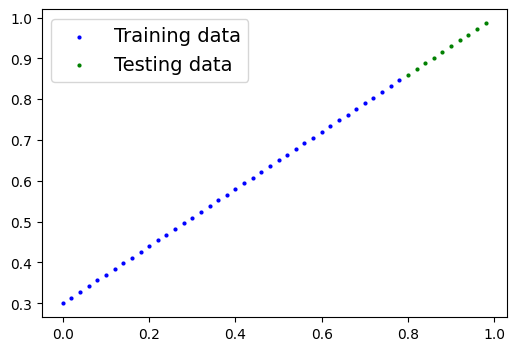

In [7]:
plot_predictions()

In [8]:
# Create linear regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch inherits from nn.Module
    # Constructor
    def __init__(self): 
        super().__init__()
        
        # Initialize model parameters
        self.weight = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

    # Forward method to define the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data
        return self.weight * x + self.bias # this is the linear regression formula

**PyTorch model building essentials**
* torch.nn - contains all of the buildings for computational graphs (a neural network can be considered a computational graph)
* torch.nn.Parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* torch.nn.Module - the base class for all neural network modules, if you subclass it, you should overwrite forward()
* torch.optim - this is where the optimizers in PyTorch live, they will help with gradient descent
* def forward() - all nn.Module subclasses require you to overwrite forward(), this method define what happens in the forward computation

In [9]:
# Create a random seed (for the reproducibility of the example, in reality we don't need to use a random seed)
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [10]:
# List of named parameters
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [11]:
X_test, y_test

(tensor([[0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

In [16]:
y_preds = model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], grad_fn=<AddBackward0>)

In [13]:
# Making prediction using torch.inference_mode()
with torch.inference_mode(): 
    # The with statement ensures that everything inside its block executes within a specific context
    # In this case the contex is: torch.inference_mode(), when the block ends Python exits the content, 
    # handling any necessary cleanup
    y_preds = model_0(X_test)

y_preds # If NotImplementedError show up: check the model class's indetation

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [ ]:
# You can also do something similar with torch.no_grad(), however, torch.inference_mode() is preferred, so use that
"""
    with torch.no_grad():
        y_preds = model_0(X_test)
"""

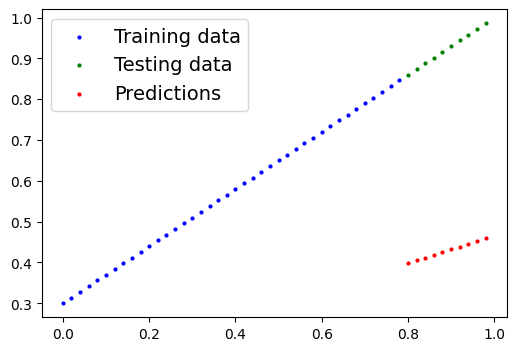

In [14]:
plot_predictions(predictions=y_preds)

In [19]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # Model's parameters
                            lr=0.01)                     # Learning rate (defualt (for SDG) is 0.1)

In [20]:
# Building a training loop (and testing loop) in PyTorch
epochs = 1 # An epoch is one loop through the data

### Training
# 0.Pass the data through the model for a number of epochs
for epoch in range(epochs):
    # Set the model to training mode
    model_0.train() # Train mode in PyTorch sets all parameters that require gradients remain differentiable
                    # This is done because some PyTorch layers and functions behave differently depending on 
                    # whether you are in train or eval mode (this is the default state of a model)

    # 1. Forward pass on train data using the forward() method inside
    y_pred = model_0(X_train)

    # 2. Calculate the loss (how different are the model's predictions to the true values)
    loss = loss_fn(y_pred, y_train) # Order: input, target

    # 3. Zero the gradients of the optimizer (they accumulate by default)
    optimizer.zero_grad()

    # 4. Permorm backpropagation on the loss
    loss.backward()

    # 5. Step the optimizer (perform gradient descent)
    optimizer.step() # By default how the optimizer changes will accumulate through the loop, so we have to zero 
                     # them above in step 3 for the next iteration of the loop

    ### Testing
    model_0.eval() # Turn off gradient tracking
